a) visulization

In [99]:
from MNIST_dataloader import *
from matplotlib import pyplot as plt
import numpy as np

#import os 
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # avoid kernel shutting down

data_loc = 'Datasets' #change the datalocation to something that works for you
batch_size = 64
    
# get dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
# get some examples
examples = enumerate(test_loader)
batch_idx, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9

In [100]:
print('train:', len(train_loader), 'test:', len(test_loader))   

train: 938 test: 157


In [121]:
train_db, val_db = torch.utils.data.random_split(train_loader, [838, 100])  
loader_train = torch.utils.data.DataLoader(train_db,batch_size=1,shuffle=True,num_workers=0)
loader_val = torch.utils.data.DataLoader(val_db,batch_size=1,shuffle=True,num_workers=0)
print('train:', len(loader_train), 'validation:', len(loader_val)) 
print(type(train_loader))
print(type(loader_val))

train: 838 validation: 100
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [122]:
examples_test = enumerate(loader_train)
batch_idx, (x_clean_example, x_noisy_example, labels_example) = next(examples_test)

TypeError: 'DataLoader' object is not subscriptable

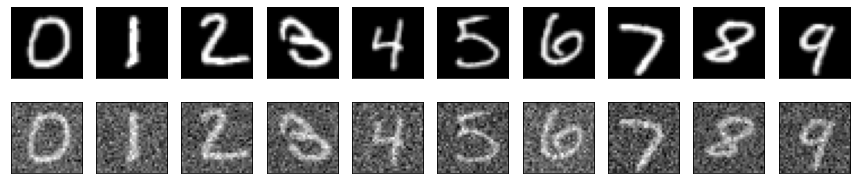

In [40]:
plt.figure(figsize=(12,3))
for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [22]:
print('image size =',x_clean_example.size())

image size = torch.Size([64, 1, 32, 32])


b) network

In [41]:
import torch.nn as nn
import torch

dtype = torch.float32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device) # check device type


cuda:0


In [42]:
# model construction
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(32*32,200),
            nn.Linear(200,200),
            nn.Linear(200,10)
        )

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.layer(x)
        return x

def build_model(model):
    model = model
    model.to(device)
    return model


In [74]:
exm = enumerate(loader_train)
exm

In [112]:
import torch.optim as optim
import torch.nn.functional as F

# train
def train(model,optimizer,epochs):

    running_loss = 0.0
    train_loss =[]

    for epoch in range(epochs):
        for batch_idx, (clean_, noise_, label_) in enumerate(train_loader):
            model.train()  # put model to training mode
            if torch.cuda.is_available():
                clean_ = clean_.cuda()
                noise_ = noise_.cuda()
                label_ = label_.cuda()
            clean_ = clean_.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            noise_ = noise_.to(device=device, dtype=dtype)
            label_ = label_.to(device=device, dtype=torch.long)

            scores = model(noise_)
            loss = F.cross_entropy(scores, label_)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()   

            running_loss += loss.item()
            if batch_idx % 200 == 199 and epoch % 5 == 4:
                print('[epoch: %d, interation: %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 200))
                running_loss = 0.0
                
    # for _, (clean_, noise_, label_) in enumerate(loader_val):
    #     if torch.cuda.is_available():
    #         clean_ = clean_.cuda()
    #         noise_ = noise_.cuda()
    #         label_ = label_.cuda()
    #     outputs = model(noise_)
    #     _, predicted = torch.max(outputs,dim=1)
    #     acc += (label_ == predicted).sum().item()
    #     total += label_.shape[0]
    # print('Val accuracy: %d %%' % (100 * acc / total))

def test(dataloader,model):
    acc = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            clean_, noise_, label_ = data
            if torch.cuda.is_available():
                clean_ = clean_.cuda()
                noise_ = noise_.cuda()
                label_ = label_.cuda()
            outputs = model(noise_)
            _, predicted = torch.max(outputs,dim=1)
            acc += (label_ == predicted).sum().item()
            total += label_.shape[0]
    print('Accuracy: %d %%' % (100 * acc / total))
             

In [113]:
learning_rate = 1e-2
linear_model = build_model(Linear())
optimizer = optim.SGD(linear_model.parameters(), lr=learning_rate)

train(linear_model, optimizer, 20)

[epoch: 5, interation:   200] loss: 8.970
[epoch: 5, interation:   400] loss: 0.330
[epoch: 5, interation:   600] loss: 0.329
[epoch: 5, interation:   800] loss: 0.333
[epoch: 10, interation:   200] loss: 6.491
[epoch: 10, interation:   400] loss: 0.311
[epoch: 10, interation:   600] loss: 0.295
[epoch: 10, interation:   800] loss: 0.300
[epoch: 15, interation:   200] loss: 6.101
[epoch: 15, interation:   400] loss: 0.292
[epoch: 15, interation:   600] loss: 0.288
[epoch: 15, interation:   800] loss: 0.311
[epoch: 20, interation:   200] loss: 5.915
[epoch: 20, interation:   400] loss: 0.286
[epoch: 20, interation:   600] loss: 0.285
[epoch: 20, interation:   800] loss: 0.300


In [195]:
print('test set(no activation):')
test(test_loader,linear_model)

test set(no activation):
Accuracy: 88 %


In [196]:
print('training set(no activation):')
test(train_loader,linear_model)

training set(no activation):
Accuracy: 91 %


c) activation

In [183]:
def Relu(x):
	a = torch.zeros_like(x)
	return torch.max(x, a)

Text(0, 0.5, 'y')

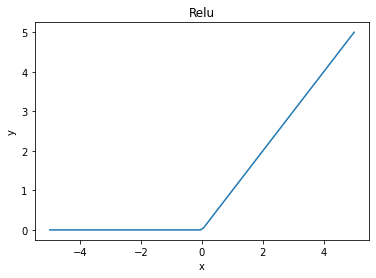

In [184]:
a_x_np = np.linspace(-5,5,100)
a_x = torch.from_numpy(a_x_np)
a_y = Relu(a_x)
plt.plot(a_x,a_y)
plt.title('Relu')
plt.xlabel('x')
plt.ylabel('y')

In [189]:
class Activation(nn.Module):
    def __init__(self):
        super().__init__()
        self.ly1 = nn.Linear(32*32,200)
        self.ly2 = nn.Linear(200,200)
        self.ly3 = nn.Linear(200,10)    

    def forward(self,x):
        x = x.view(-1,32*32)
        x = self.ly1(x)
        x = Relu(x)
        x = self.ly2(x)
        x = Relu(x)
        x = self.ly3(x)
        return x

def build_model(model):
    model = model
    model.to(device)
    return model

In [190]:
learning_rate = 1e-2
activation_model = build_model(Activation())
optimizer = optim.SGD(activation_model.parameters(), lr=learning_rate)

train(activation_model, optimizer, 20)

[epoch: 5, interation:   200] loss: 9.626
[epoch: 5, interation:   400] loss: 0.290
[epoch: 5, interation:   600] loss: 0.277
[epoch: 5, interation:   800] loss: 0.284
[epoch: 10, interation:   200] loss: 4.551
[epoch: 10, interation:   400] loss: 0.175
[epoch: 10, interation:   600] loss: 0.180
[epoch: 10, interation:   800] loss: 0.175
[epoch: 15, interation:   200] loss: 2.936
[epoch: 15, interation:   400] loss: 0.116
[epoch: 15, interation:   600] loss: 0.111
[epoch: 15, interation:   800] loss: 0.116
[epoch: 20, interation:   200] loss: 1.950
[epoch: 20, interation:   400] loss: 0.077
[epoch: 20, interation:   600] loss: 0.078
[epoch: 20, interation:   800] loss: 0.083


In [198]:
print('test set(with Relu()):')
test(test_loader,activation_model)

test set(with Relu()):
Accuracy: 94 %


In [197]:
print('training set(with Relu()):')
test(train_loader,activation_model)

training set(with Relu()):
Accuracy: 98 %
